## Import and split data

In [177]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import warnings
warnings.simplefilter('ignore')
bikes=pd.read_csv('train.csv', index_col=0, parse_dates=True)

In [178]:
from sklearn.model_selection import train_test_split

def dfSplitter(df):
    #split data to training and testing data sets 
    y=df['count']
    X=df.iloc[:, :10]
    xTrain, xTest, yTrain, yTest=train_test_split(X, y, train_size=0.8, random_state=42)
    return(xTrain, xTest, yTrain, yTest)

In [179]:
xTrain, xTest, yTrain, yTest=dfSplitter(bikes)

In [153]:
#remerge training data for EDA
dfTrain=pd.concat([yTrain, xTrain], axis=1)

## Cleanup data for EDA

In [154]:
def cleanerX(X):
    X['month']=X.index.month
    X['day']=X.index.weekday
    X['hour']=X.index.hour
    X['dayName']=X.index.day_name()

In [155]:
cleanerX(dfTrain)

## Exploratory Data Analysis (EDA)

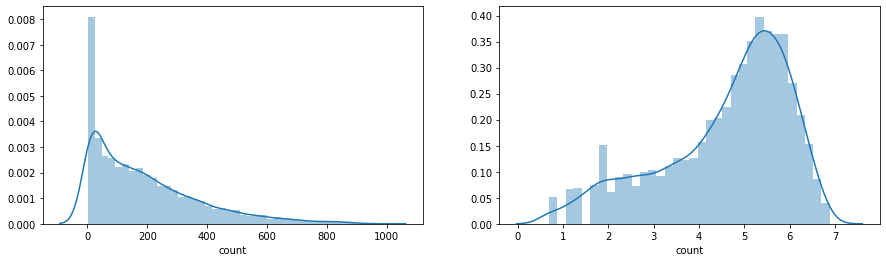

In [7]:
#take a look at count distribution vs log count 
fig, g=plt.subplots(1,2, figsize=(15,4))
sns.distplot(dfTrain['count'], ax=g[0])
sns.distplot(np.log1p(dfTrain['count']), ax=g[1])

**Taking the log of count seems to take away a good part of the skewness, something to consider doing when building model**

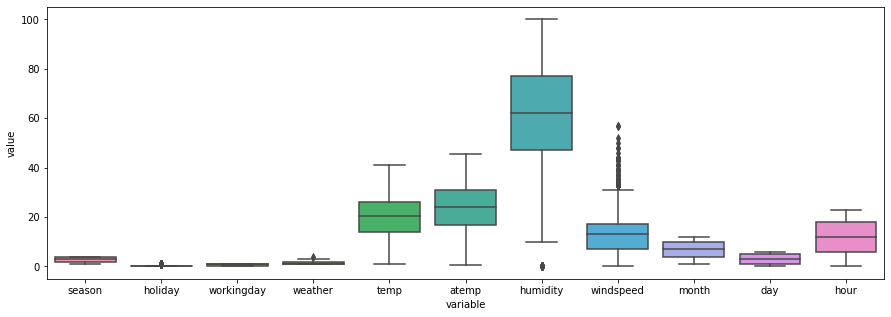

In [8]:
#take a look to see if there are any outliers 
plt.figure(figsize=(15,5))
sns.boxplot(x='variable', y='value', 
            data=pd.melt(dfTrain.drop(['count', 'casual', 'registered', 'dayName'], axis=1)))

**Outliers present in humidity and windspeed. If they are features to be included in the model then will have regularize the model**

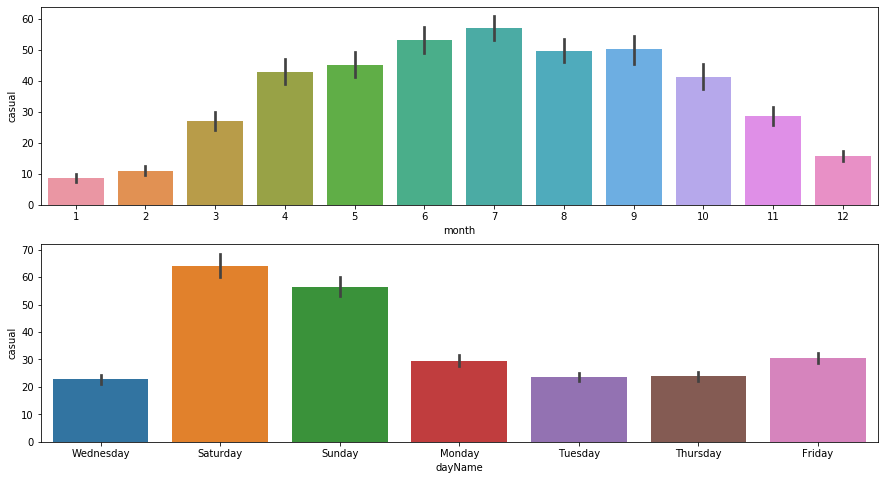

In [9]:
#take a look at monthly and daily usuage for casual riders 
fig, g=plt.subplots(2,1, figsize=(15,8))
sns.barplot(x='month', y='casual', data=dfTrain, ax=g[0])
sns.barplot(x='dayName', y='casual', data=dfTrain, ax=g[1])

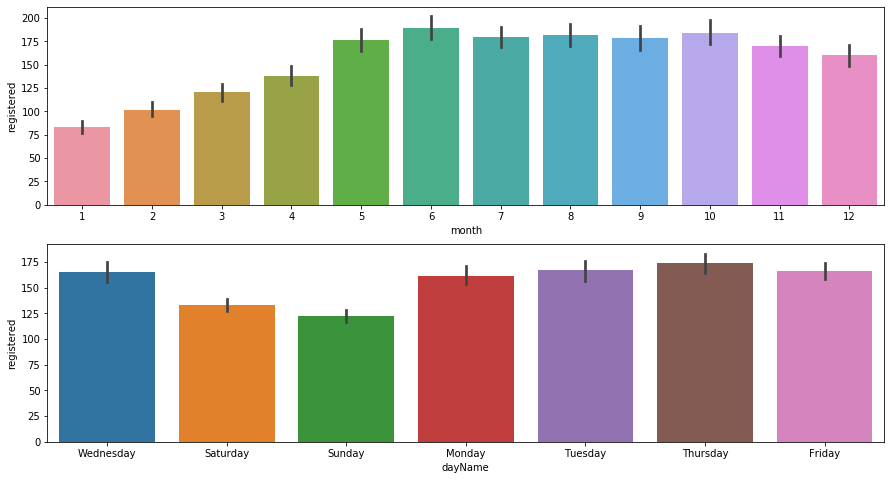

In [10]:
#take a look at monthly and daily usage for registered riders 
fig, g=plt.subplots(2,1, figsize=(15,8))
sns.barplot(x='month', y='registered', data=dfTrain, ax=g[0])
sns.barplot(x='dayName', y='registered', data=dfTrain, ax=g[1])

**More variability in bike rental with casual users in comparison to regular users**

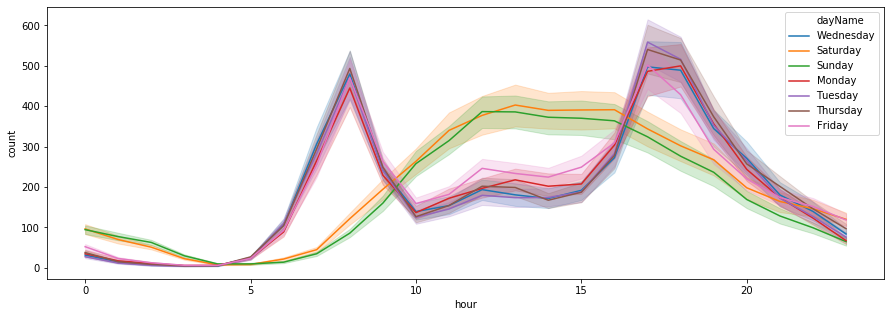

In [11]:
#take a look at hourly usage throughout the week for all riders 
plt.figure(figsize=(15,5))
sns.lineplot(x='hour', y='count', data=dfTrain, hue='dayName')

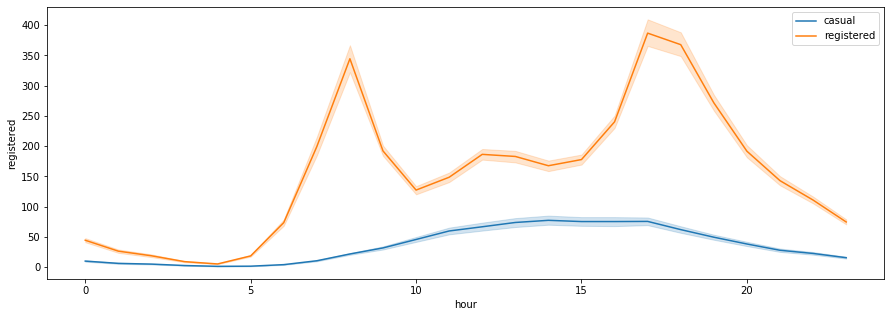

In [12]:
#take a look at daily hourly usage for casual vs registered riders 
plt.figure(figsize=(15,5))
sns.lineplot(x='hour', y='casual', data=dfTrain, label='casual')
sns.lineplot(x='hour', y='registered', data=dfTrain, label='registered')

**Consistent bike rental by casual users through out the week and time of day. Regular users peak usage during rush hour (going to and from work for example)**

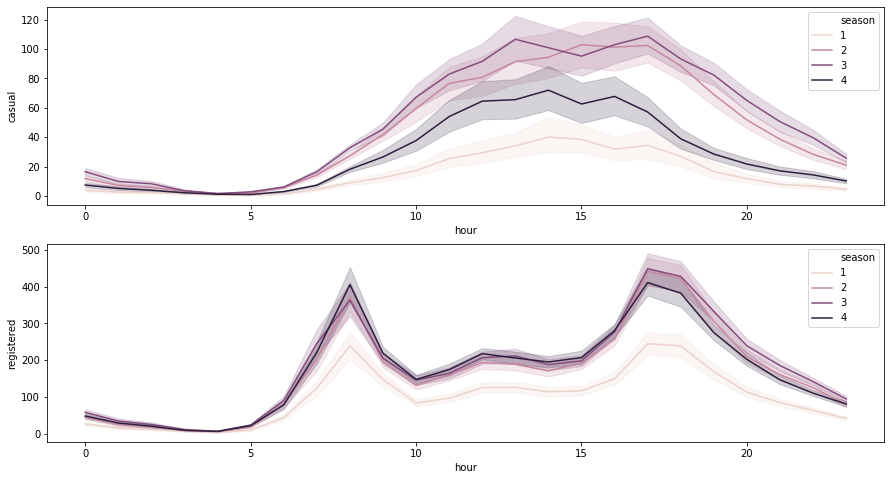

In [13]:
fig, g=plt.subplots(2,1, figsize=(15,8))
sns.lineplot(x='hour', y='casual', data=dfTrain, hue='season', ax=g[0])
sns.lineplot(x='hour', y='registered', data=dfTrain, hue='season', ax=g[1])

**Neither season nor weather play a role in bike rental for casual or regualr users**

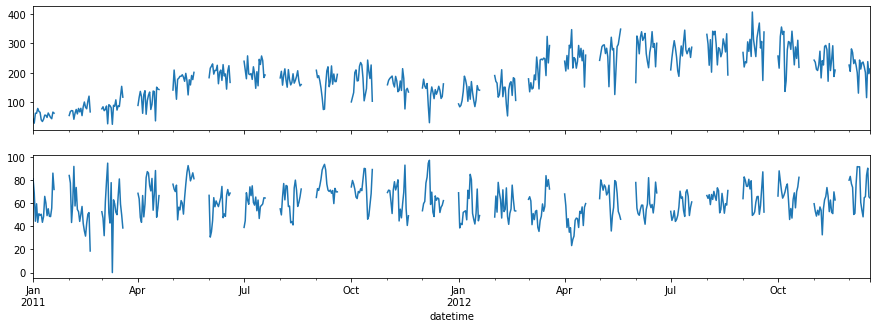

In [10]:
#compare bike usage to humidity changes throughout the year 
fig, g=plt.subplots(2,1,figsize=(15,5), sharex=True)
dfTrain['count'].resample('1D').mean().plot(ax=g[0])
dfTrain['humidity'].resample('1D').mean().plot(ax=g[1])

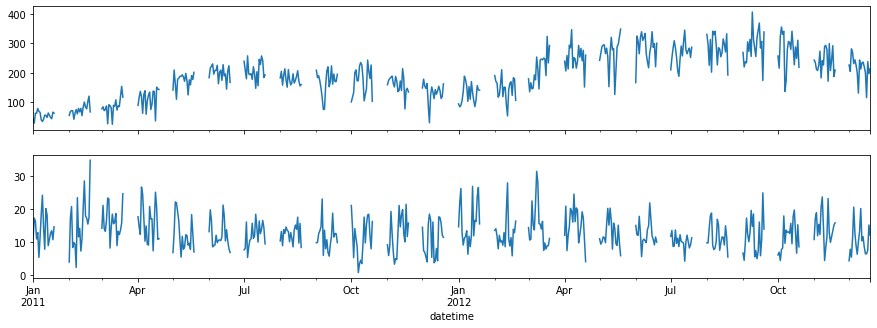

In [19]:
#compare bike usage throughout the year with wind conditions 
fig, g=plt.subplots(2,1,figsize=(15,5), sharex=True)
dfTrain['count'].resample('1D').mean().plot(ax=g[0])
dfTrain['windspeed'].resample('1D').mean().plot(ax=g[1])

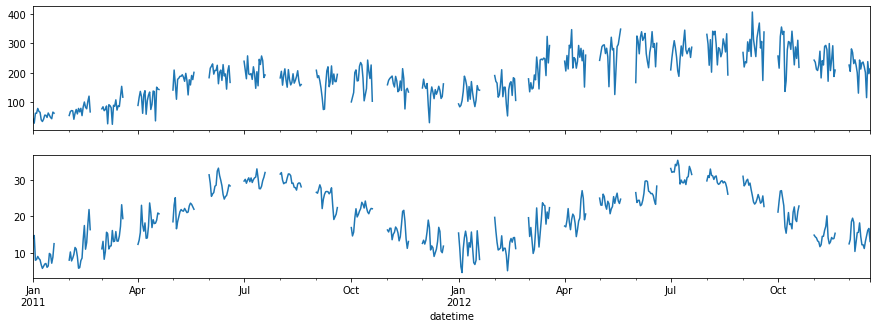

In [20]:
#compare bike usage throughout the year with temp fluctuations 
fig, g=plt.subplots(2,1,figsize=(15,5), sharex=True)
dfTrain['count'].resample('1D').mean().plot(ax=g[0])
dfTrain['temp'].resample('1D').mean().plot(ax=g[1])

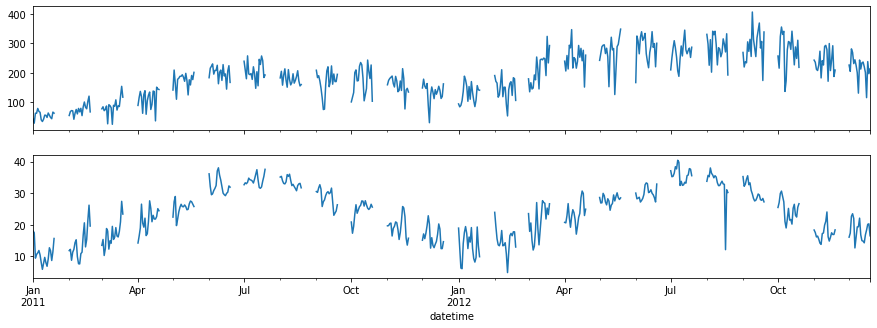

In [21]:
#compare bike usage with feeling temp fluctuations throughout the year 
fig, g=plt.subplots(2,1,figsize=(15,5), sharex=True)
dfTrain['count'].resample('1D').mean().plot(ax=g[0])
dfTrain['atemp'].resample('1D').mean().plot(ax=g[1])

**temperature and ambient temperature fluctuate similarly to bike count, indicate that plays a role in user count**

## Fetaure Selection

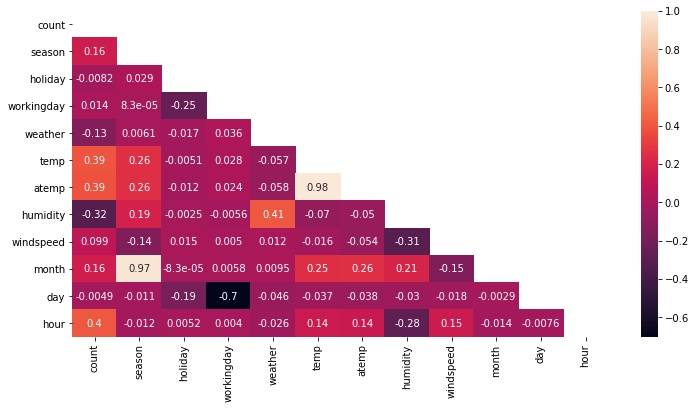

In [26]:
#examine which features correlate closests with each other 
plt.figure(figsize=(12, 6))
corr=dfTrain.drop(['casual', 'registered', 'dayName'],axis=1).corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, annot=True, mask=mask)

**apparent covariants: month/season and temp/atemp**

In [27]:
#select significant features 
from statsmodels.regression.linear_model import OLS
dfTrain['w0']=1
m=OLS(dfTrain['count'], 
      dfTrain[['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 
                'windspeed', 'casual', 'registered', 'month', 'day', 'hour', 'w0']])
resultM=m.fit()
featureTable= pd.DataFrame(round(resultM.pvalues, 5), 
                           index=dfTrain.drop(['count','casual','registered','dayName',
                            'w0'],axis=1).columns, 
                           columns=['feature pval']).sort_values('feature pval')
featureTable

,feature pval
holiday,0.00000
atemp,0.00000
humidity,0.00000
hour,0.00000
month,0.00002
workingday,0.00008
season,0.00185
temp,0.00229
weather,0.44976
windspeed,0.67689


In [28]:
X=dfTrain.drop(['count','casual','registered', 'w0', 'dayName'], axis=1)
y=dfTrain['count']
from sklearn.linear_model import LinearRegression
estimator=LinearRegression()
from sklearn.feature_selection import RFE
selector=RFE(estimator)
selector=selector.fit(X,y)
for feature, decision in zip(X.columns, selector.support_):
    print(feature, ':', decision)
featureTable= pd.DataFrame(selector.ranking_, index=X.columns, 
                                     columns=['feature importance']).sort_values('feature importance')
display(featureTable)

season : True
holiday : True
workingday : False
weather : False
temp : False
atemp : True
humidity : False
windspeed : False
month : True
day : False
hour : True


,feature importance
season,1
holiday,1
atemp,1
month,1
hour,1
humidity,2
weather,3
temp,4
workingday,5
windspeed,6


**From EDA and feature selection, the ones that are worth a try for modeling: hour, workingday,  atemp, humidity, month,  and holiday**

## Feature Engineering I

#### Creating time peaks and interacting terms

In [156]:
cleanerX(xTrain)

In [157]:
def featEng(X):
    #creating month columns for peaks in june nad july 
    X['mJun']=np.abs(X['month']-6) 
    X['mJul']=np.abs(X['month']-7)
    #creating peak time columns
    X['8h']=np.abs(X['hour']-8)
    X['18h']=np.abs(X['hour']-18)
    #interaction terms 
    X['mJulHol']=X['mJul']*X['holiday']
    X['mJunWD']=X['mJun']*X['workingday']
    X['mJultemp']=X['mJul']*X['temp']
    X['mJulHum']=X['mJul']*X['humidity']
    return(X)

In [158]:
def featEng2(X,y):
    #remove problematic column
    X.drop(['dayName', 'casual', 'registered'], axis=1, inplace=True)
    #calculate log of count
    y=np.log1p(y)
    return(X,y)

In [159]:
xTrain=featEng(xTrain)

In [160]:
xTrain, yTrain=featEng2(xTrain, yTrain)

## Model tesing and evaluation II

In [161]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_log_error

def testMod(X, y, xIndex, modName, modType):
    r2List=[]
    rmsleList=[]
    X=X
    
    sns.lineplot(x=X.index.month, y=y, label='y True')
    for i in range(len(xIndex)):
        if modType=='LR':
            m=LinearRegression()
        elif modType=='DT':
            m=DecisionTreeRegressor()
        elif modType=='RF':
            m=RandomForestRegressor()
        X1=X[xIndex[i]] 
        m.fit(X1, y)
        r2=m.score(X1,y)
        r2List.append(r2)
        X['ypred']=m.predict(X1)
        sns.lineplot(x=X.index.month, y=X['ypred'], label=modName[i])
        rmsle=np.sqrt(mean_squared_log_error(y, X['ypred']))
        rmsleList.append(rmsle)
    plt.legend(loc='lower right')
    plt.show()
    r2Table=pd.DataFrame({'model':modName, '$r^2$':r2List, 'RMSLE':rmsleList})
    display(r2Table)

In [165]:
basic=['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
        'humidity', 'windspeed', 'month', 'day', 'hour']
edaList=['hour', 'atemp','humidity','month','workingday','holiday']
feList=['mJulHol','mJunWD','mJultemp','mJulHum', '8h', '18h']
xIndex=[basic, edaList, feList, edaList+feList, basic+edaList+feList]
modName=['noAnalysis', 'EDA', 'Interact', 'EDA+Interact', 'noAnalysis+EDA+Interact']

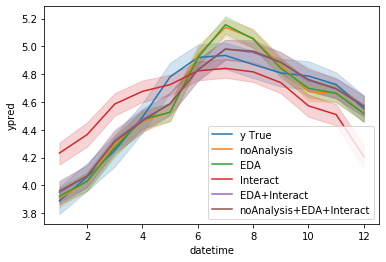

,model,$r^2$,RMSLE
0,noAnalysis,0.463302,0.234494
1,EDA,0.462634,0.234616
2,Interact,0.583664,0.219528
3,EDA+Interact,0.617996,0.212053
4,noAnalysis+EDA+Interact,0.622844,0.211226


In [166]:
##'LR'=LinearRegression, 'DT'=DecisionTree 'RF'=RandomForest
testMod(xTrain, yTrain, xIndex, modName, 'LR')

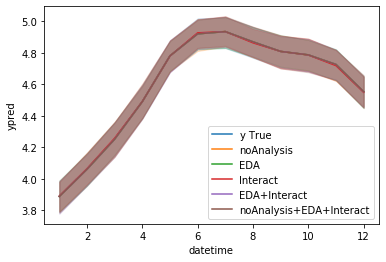

,model,$r^2$,RMSLE
0,noAnalysis,0.999993,0.001062
1,EDA,0.996539,0.018873
2,Interact,0.989696,0.033949
3,EDA+Interact,0.997193,0.017162
4,noAnalysis+EDA+Interact,0.999993,0.001062


In [167]:
##'LR'=LinearRegression, 'DT'=DecisionTree 'RF'=RandomForest
testMod(xTrain, yTrain, xIndex, modName, 'DT')

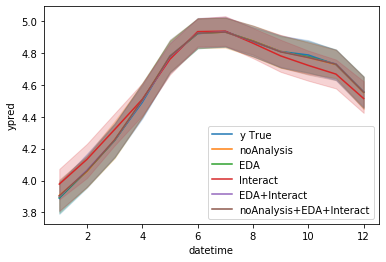

,model,$r^2$,RMSLE
0,noAnalysis,0.990249,0.036371
1,EDA,0.985630,0.042589
2,Interact,0.974100,0.055947
3,EDA+Interact,0.986389,0.041765
4,noAnalysis+EDA+Interact,0.990383,0.036093


In [139]:
##'LR'=LinearRegression, 'DT'=DecisionTree 'RF'=RandomForest
testMod(xTrain, yTrain, xIndex, modName, 'RF')

**When comparing linear regression, decision tree and random forest, the interacting features provide the greatest boost to the model. Decision tree overfitted the data. Random forest didn't overfit the model to the data as much**

## Feature Scaling II (Scaling Features)

In [140]:
#prepare new training and testing sets for scaling 
xTrain, xTest, yTrain, yTest=dfSplitter(bikes)
cleanerX(xTrain)
xTrain, yTrain=featEng2(xTrain, yTrain)

In [141]:
from sklearn.preprocessing import StandardScaler

def dfScalar(X):
    #extract necessary scales for after standard scaling 
    ts=X.index  
    col=X.columns
    #perform scaling transformation
    sc=StandardScaler()
    dfTrain=sc.fit_transform(X)
    #convert numpy array back to df
    dfTrain=pd.DataFrame(dfTrain, columns=col, index=ts)
    return(X)

In [142]:
#scale all x and y features 
xTrain=dfScalar(xTrain)
xTrain=featEng(xTrain)

In [143]:
#make sure use right columns for modeling 
xTrain.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'month', 'day', 'hour', 'mJun', 'mJul', '8h',
       '18h', 'mJulHol', 'mJunWD', 'mJultemp', 'mJulHum'],
      dtype='object')

In [144]:
basic=['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
        'humidity', 'windspeed', 'month', 'day', 'hour']
edaList=['hour','atemp','humidity','month','workingday','holiday']
feList=['mJulHol','mJunWD','mJultemp','mJulHum', '8h', '18h']
xIndex=[basic, edaList, feList, edaList+feList, basic+edaList+feList]
modName=['noAnalysis', 'EDA', 'Interact', 'EDA+Interact', 'noAnalysis+EDA+Interact']

## Model Testing and Evaluation II (Scaling Features)

In [145]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_log_error

def testModScalar(X, y, xIndex, modName, modType):
    r2List=[]
    rmsleList=[]
    X=X
    
    sns.lineplot(x=X.index.month, y=y, label='y True')
    for i in range(len(xIndex)):
        if modType=='LR':
            m=LinearRegression()
        elif modType=='DT':
            m=DecisionTreeRegressor()
        elif modType=='RF':
            m=RandomForestRegressor()
        X1=X[xIndex[i]] 
        m.fit(X1, y)
        r2=m.score(X1,y)
        r2List.append(r2)
        X['ypred']=m.predict(X1)
        sns.lineplot(x=X.index.month, y=X['ypred'], label=modName[i])
        rmsle=np.sqrt(mean_squared_log_error(y, X['ypred']))
        rmsleList.append(rmsle)
    plt.legend(loc='lower right')
    plt.show()
    r2Table=pd.DataFrame({'model':modName, '$r^2$':r2List, 'RMSLE':rmsleList})
    display(r2Table)

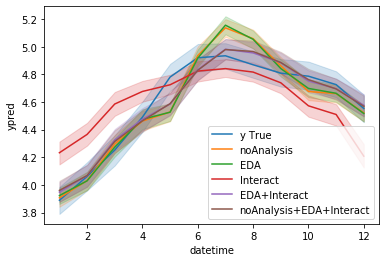

,model,$r^2$,RMSLE
0,noAnalysis,0.463302,0.234494
1,EDA,0.462634,0.234616
2,Interact,0.583664,0.219528
3,EDA+Interact,0.617996,0.212053
4,noAnalysis+EDA+Interact,0.622844,0.211226


In [146]:
testModScalar(xTrain, yTrain, xIndex, modName, 'LR')

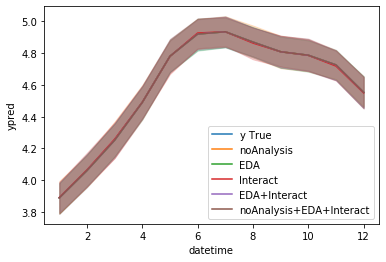

,model,$r^2$,RMSLE
0,noAnalysis,0.999993,0.001062
1,EDA,0.996539,0.018873
2,Interact,0.989696,0.033949
3,EDA+Interact,0.997193,0.017162
4,noAnalysis+EDA+Interact,0.999993,0.001062


In [147]:
testModScalar(xTrain, yTrain, xIndex, modName, 'DT')

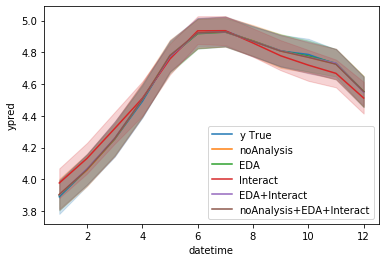

,model,$r^2$,RMSLE
0,noAnalysis,0.990312,0.036188
1,EDA,0.985670,0.042267
2,Interact,0.974149,0.055985
3,EDA+Interact,0.986449,0.041477
4,noAnalysis+EDA+Interact,0.990341,0.036136


In [148]:
testModScalar(xTrain, yTrain, xIndex, modName, 'RF')

**Scaling the features produced the same accuracy as before, it may have just sped up the algorithm iteration.**

## Checking Assumptions

In [136]:
#prepare new training and testing sets for scaling 
xTrain, xTest, yTrain, yTest=dfSplitter(bikes)
cleanerX(xTrain)
xTrain, yTrain=featEng2(xTrain, yTrain)
xTrain=featEng(xTrain)

In [137]:
xTrain=xTrain[['hour','atemp','humidity','month','workingday','holiday','mJulHol','mJunWD','mJultemp','mJulHum', '8h', '18h']]

In [138]:
df=pd.concat([yTrain, xTrain], axis=1)

**verify linear relationship between variables**

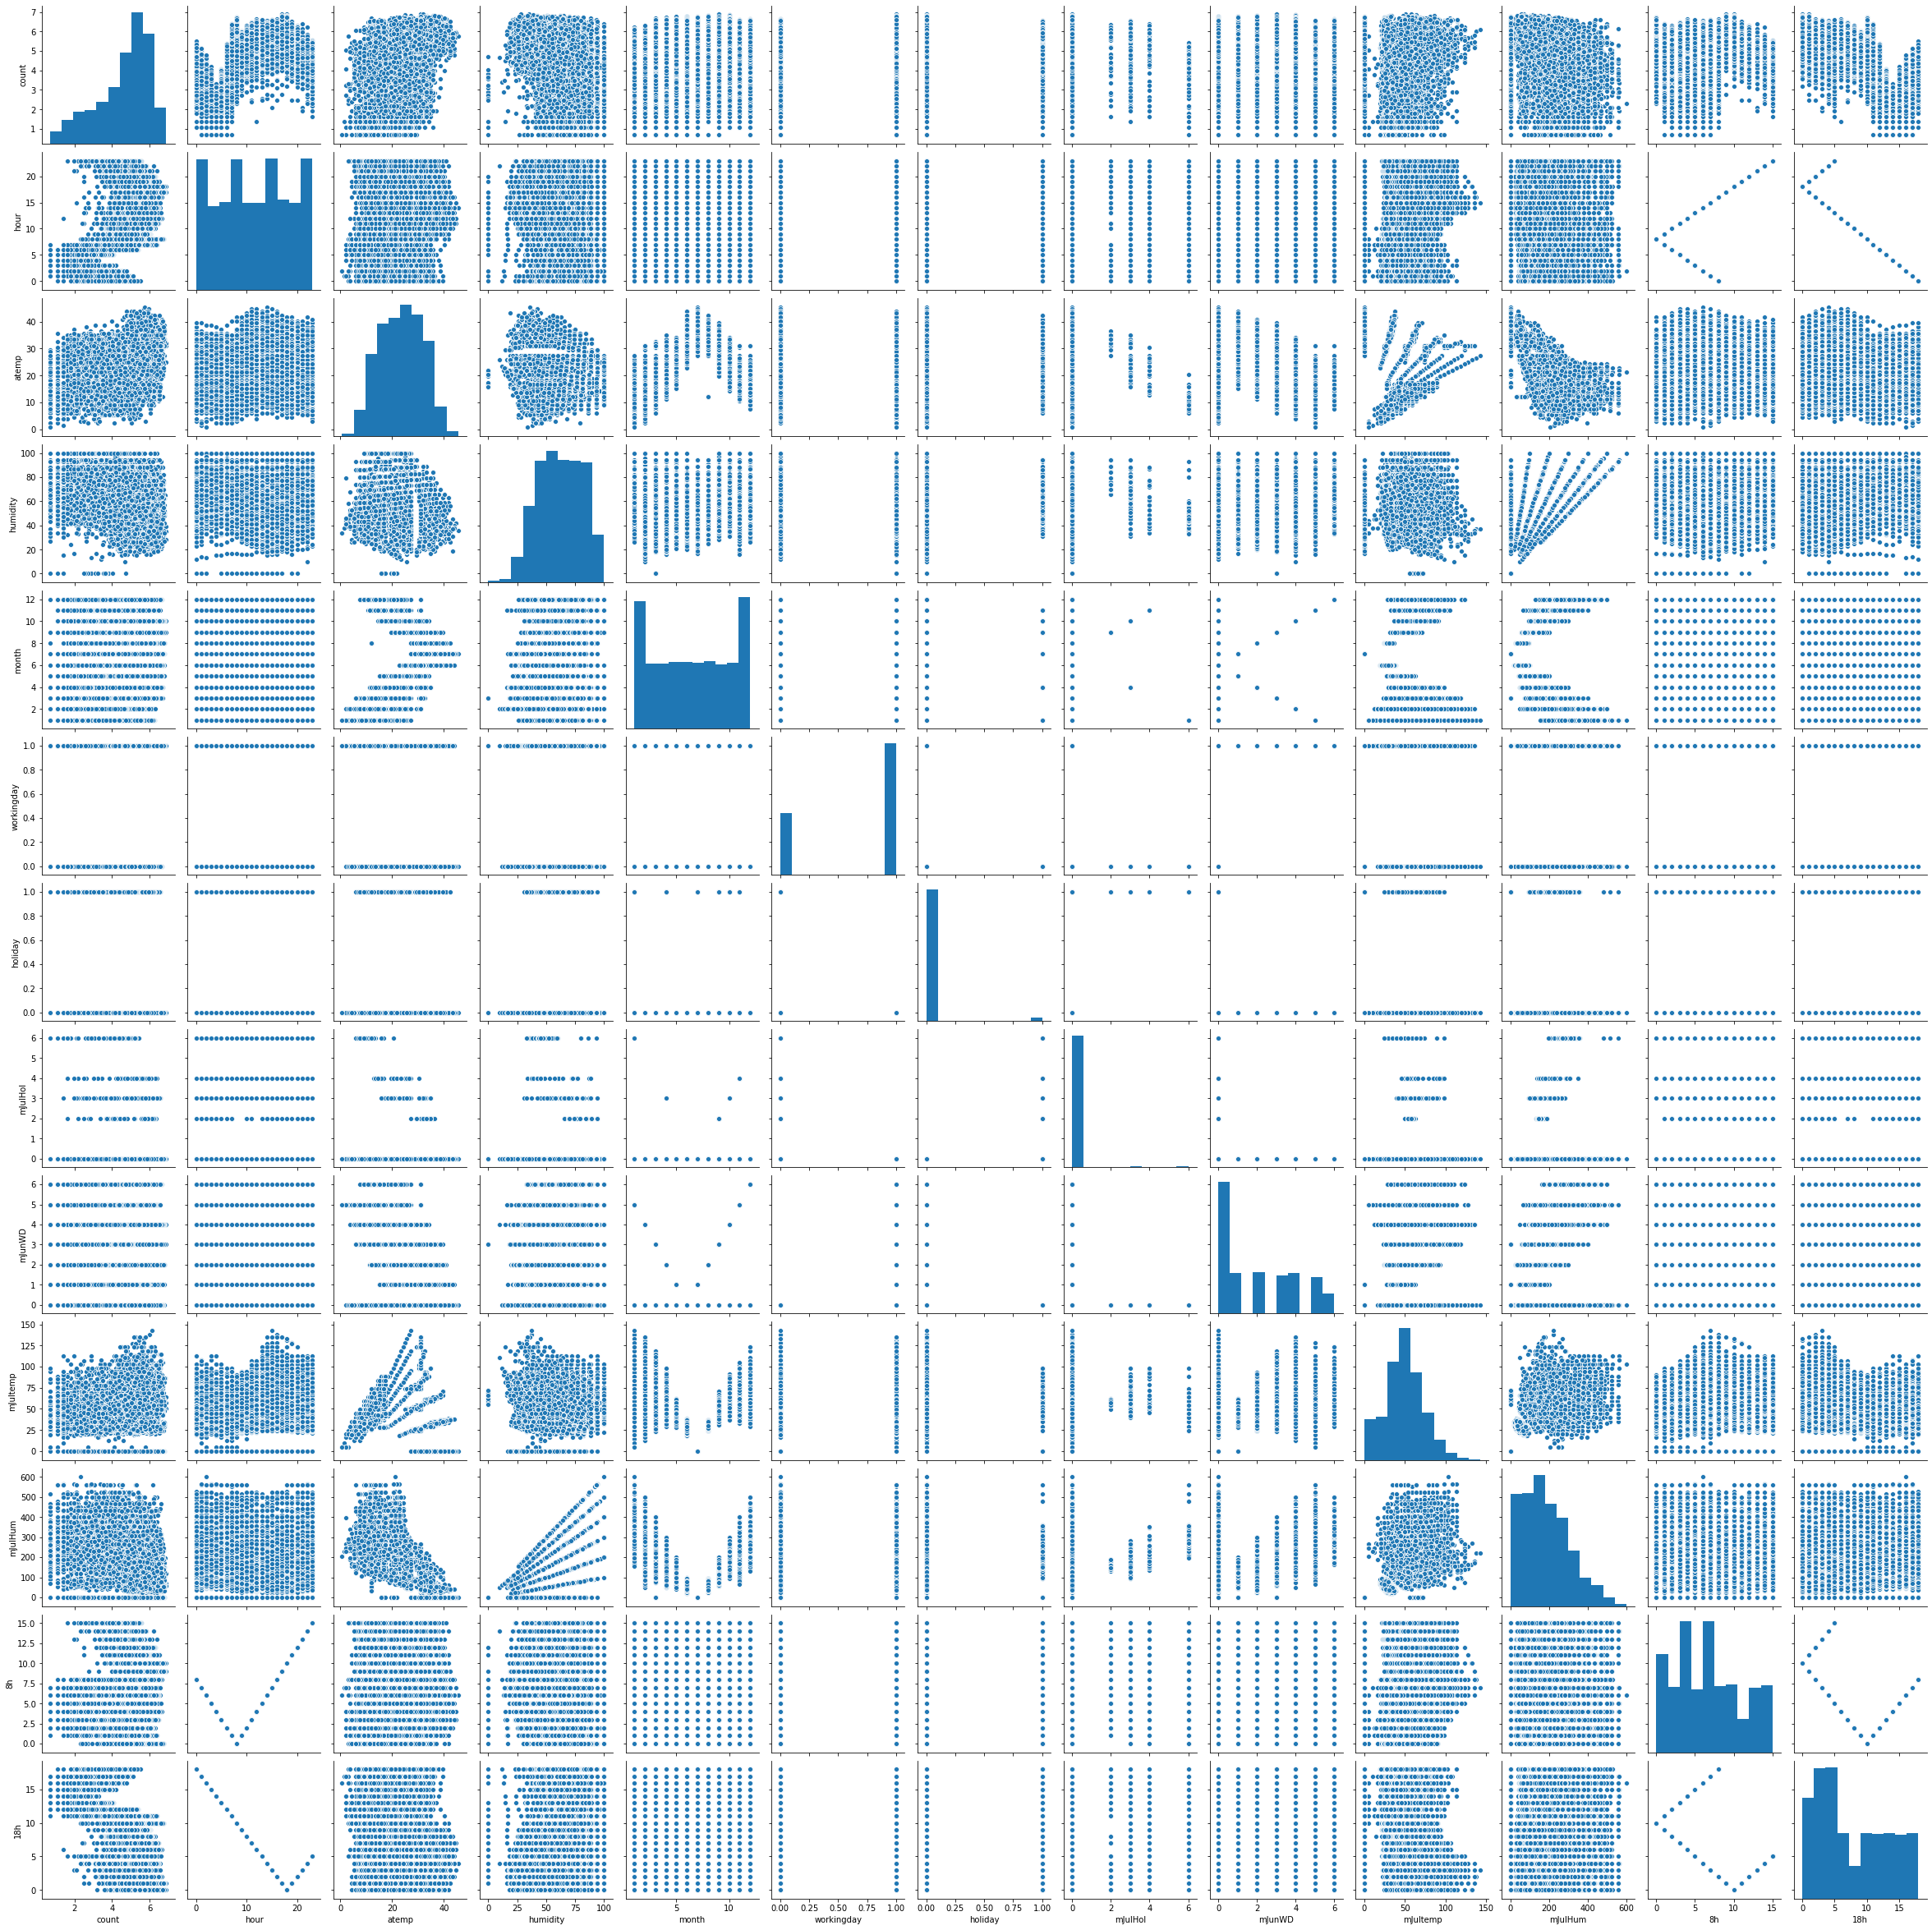

In [54]:
sns.pairplot(df)

*Observed in general linear relationship between count and independent variables*

**Verify there is variation amount the x variables**

In [55]:
df.nunique()

count         800
hour           24
atemp          60
humidity       88
month          12
workingday      2
holiday         2
mJulHol         5
mJunWD          7
mJultemp      108
mJulHum       279
8h             16
18h            19
dtype: int64

*all input values have minimum 2 values*

**Verify zero conditional mean assumption: $E(\epsilon|X)=0$**

In [139]:
from sklearn.linear_model import LinearRegression
m=LinearRegression()
m.fit(df.drop('count', axis=1), df['count'])
df['ypred']=m.predict(df.drop('count', axis=1))
df['resids']=df['count']-df['ypred']

In [75]:
df.cov().iloc[-1:,:].transpose()

,resids
count,7.654989e-01
hour,7.824376e-15
atemp,2.380118e-14
humidity,-6.321521e-14
month,-1.177165e-15
workingday,-9.945721e-19
holiday,-8.932023e-18
mJulHol,-1.948596e-16
mJunWD,-3.726330e-15
mJultemp,-5.211028e-14


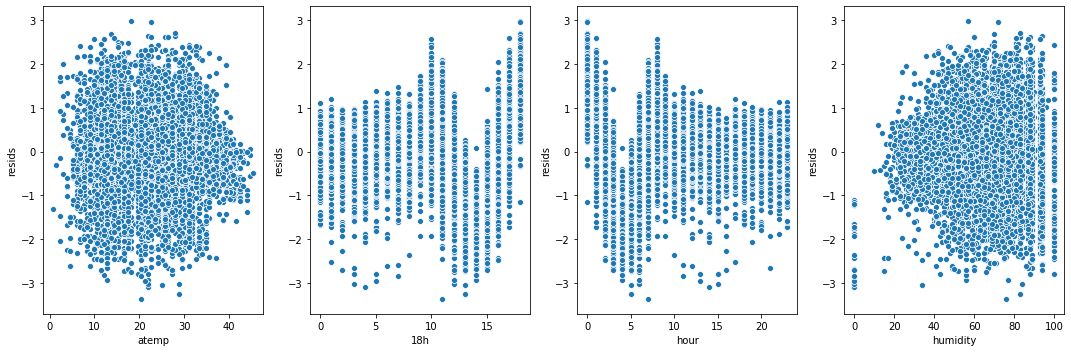

In [107]:
fig, g=plt.subplots(1,4, figsize=(15,5))
sns.scatterplot(x='atemp', y='resids', data=df, ax=g[0])
sns.scatterplot(x='18h', y='resids', data=df, ax=g[1])
sns.scatterplot(x='hour', y='resids', data=df, ax=g[2])
sns.scatterplot(x='humidity', y='resids', data=df, ax=g[3])
plt.tight_layout()

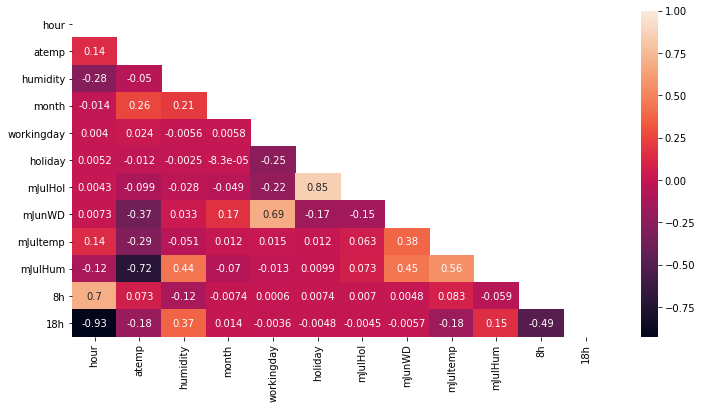

In [148]:
plt.figure(figsize=(12, 6))
corr=xTrain.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, annot=True, mask=mask)

In [86]:
from statsmodels.regression.linear_model import OLS
df['w0']=1
m=OLS(df['count'], df.drop('count', axis=1))
resultM=m.fit()
resultM.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.915e+30
Date:                Sun, 07 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:09:26   Log-Likelihood:             2.6171e+05
No. Observations:                8708   AIC:                        -5.234e+05
Df Residuals:                    8694   BIC:                        -5.233e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
hour           0.0011   1.48e-16   7.14e+12      0.000       0.001       0.001
atemp          0.0011    6.1e-17   1.76e+13      0.000       0.001       0.001
humidity      -0.0003    2.1e-17   -1.2e+13      0.000      -0.000      -0.000
month          0.0018   8.68e-17   2.13e+13      0.000       0.002       0.002
workingday    -0.0013   8.89e-16  -1.47e+12      0.000      -0.001      -0.001
holiday     7.182e-05    2.7e-15   2.66e+10      0.000    7.18e-05    7.18e-05
mJulHol       -0.0009    7.1e-16  -1.22e+12      0.000      -0.001      -0.001
mJunWD        -0.0004   2.46e-16  -1.56e+12      0.000      -0.000      -0.000
mJultemp    9.256e-05   1.48e-17   6.27e+12      0.000    9.26e-05    9.26e-05
mJulHum    -1.286e-05   4.97e-18  -2.58e+12      0.000   -1.29e-05   -1.29e-05
8h            -0.0034   1.25e-16  -2.76e+13      0.000      -0.003      -0.003
18h           -0.0052   9.31e-17  -5.55e+13      0.000      -0.005      -0.005
ypred          0.9674   4.85e-16   1.99e+15      0.000       0.967       0.967
resids         1.0000   2.63e-16    3.8e+15      0.000       1.000       1.000
w0             0.1776   9.06e-17   1.96e+15      0.000       0.178       0.178
==============================================================================
Omnibus:                      133.643   Durbin-Watson:                   1.083
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              136.095
Skew:                          -0.292   Prob(JB):                     2.80e-30
Kurtosis:                       2.818   Cond. No.                     5.69e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.47e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

*OLS indicates there may be multicolinearity, will test for this*

In [99]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant 
xTrain=add_constant(xTrain)
VIF=pd.DataFrame([variance_inflation_factor(xTrain.values, i) for i in range(xTrain.shape[1])], index=xTrain.columns)
display(VIF)

,0
const,140.767078
hour,16.483069
atemp,3.665535
humidity,2.826972
month,1.473112
workingday,3.262166
holiday,3.917399
mJulHol,3.925040
mJunWD,4.628158
mJultemp,2.294259


In [104]:
#attempt to reduce colinearity by dropping hour
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant 
xTrain2=xTrain.drop('hour', axis=1, inplace=True)
xTrain2=add_constant(xTrain)
VIF=pd.DataFrame([variance_inflation_factor(xTrain2.values, i) for i in range(xTrain2.shape[1])], index=xTrain2.columns)
display(VIF)

,0
const,47.801283
atemp,3.605517
humidity,2.744895
month,1.473109
workingday,3.262026
holiday,3.917317
mJulHol,3.924913
mJunWD,4.628157
mJultemp,2.277859
mJulHum,7.199511


**Verify homoscedasticity of the model**

In [140]:
from statsmodels.stats.diagnostic import het_breuschpagan
het_breuschpagan(df['resids'], df.drop('count', axis=1))

(2273.9205130835658, 0.0, 236.35518887474734, 0.0)

*with the last value being less than 0.05, heteroskedasticity is present in the model*

**Verify residuals are normally distibuted**

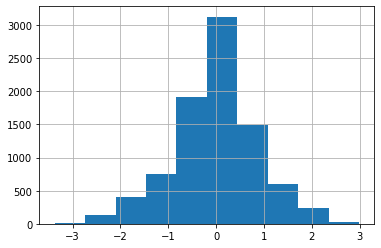

In [141]:
df['resids'].hist()

((array([-3.77627465, -3.5491955 , -3.42443716, ...,  3.42443716,
          3.5491955 ,  3.77627465]),
  array([-3.37263702, -3.24199339, -3.08448579, ...,  2.71910783,
          2.95587988,  2.98698533])),
 (0.8696722064294169, 2.395139398799735e-16, 0.993647149939784))

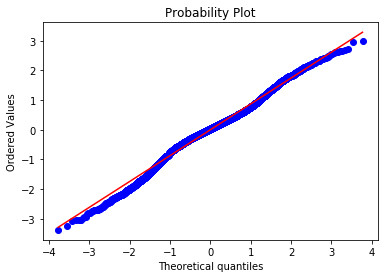

In [142]:
from scipy.stats import probplot
import matplotlib.pyplot as plt
probplot(df['resids'], plot=plt)

In [144]:
from scipy.stats import jarque_bera
jarque_bera(df['resids'])

(197.9881448366206, 0.0)

*the null hypothesis is rejected in the jarque_bera test, so can't confidently say that the residuals are normally distributed*

**For assumption evaluation, most assumptions aren't violated except for normal residual distribution, homoscedasticity and multicolinearity**

## Retry modeling without hour and atemp

In [190]:
#prepare new training and testing sets for scaling 
xTrain, xTest, yTrain, yTest=dfSplitter(bikes)
cleanerX(xTrain)
xTrain, yTrain=featEng2(xTrain, yTrain)
xTrain=featEng(xTrain)

In [191]:
basic=['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
        'humidity', 'windspeed', 'month', 'day', 'hour']
edaList=['hour', 'atemp','humidity','month','workingday','holiday']
feList=['mJulHol','mJunWD','mJultemp','mJulHum', '8h', '18h']
xIndex=[basic, edaList, feList, edaList+feList]
modName=['noAnalysis', 'EDA', 'Interact', 'EDA+Interact']

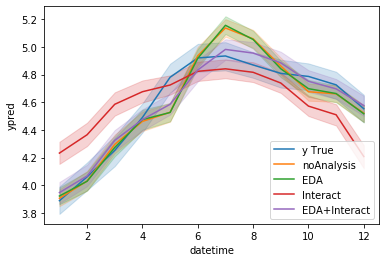

,model,$r^2$,RMSLE
0,noAnalysis,0.463302,0.234494
1,EDA,0.462634,0.234616
2,Interact,0.583664,0.219528
3,EDA+Interact,0.617996,0.212053


In [192]:
testMod(xTrain, yTrain, xIndex, modName, 'LR')